## Proprietà dell'acqua

Proprietà dell'acqua in fase gassosa e liquida. Dati dal sito del NIST (National Instutute of Standards and Technology) https://webbook.nist.gov/chemistry/fluid/.

In [ ]:
import numpy

data = {}
header = open('water/T750.txt').readline().strip().split('\t')
for T in [750, 647, 643, 600, 550]:
    data[T] = numpy.loadtxt('water/T{}.txt'.format(T), skiprows=1, unpack=True, converters={-1: lambda x: 0})

### Limiti di validità dell'equazione dei gas perfetti
Testiamo i limiti di validità dell'equazione di stato dei gas perfetti: 

- in quale range di pressione, temperatura e densità fornisce una buona descrizione delle proprietà del vapore d'acqua?
- cosa succede a bassa temperatura?

In [ ]:
from matplotlib import pyplot as plt

def pressure_ideal_gas(V, T, n=1.0):
    R = 8.314
    return n * R * T / V
    
#plt.ylim(0, 50)
plt.xlabel('V')
plt.ylabel('P')
T = 750
plt.plot(data[T][3], 1e6 * data[T][1], 'o', label='T=750')
# Convert units!
plt.plot(data[T][3], pressure_ideal_gas(1e-3 * data[T][3], T), label='ideal gas')
plt.legend()

### Equazione di stato di van der Waals 


$$
(P+a\frac{n^2}{V^2})(V-nb) = nR T
$$
Valori delle costanti $a$ e $b$ https://en.wikipedia.org/wiki/Van_der_Waals_constants_(data_page)

- implementa $P(V,T)$ secondo l'equazione di stato di van der Waals
- usa i valori di $a$ e $b$ adatti per l'acqua (in unità SI)

In [ ]:
from matplotlib import pyplot as plt

def pressure_vdw(V, T, a=0.0, b=0.0, n=1.0):
    R = 8.314
    # TODO: return vdw expression for P
    # TODO: values of a and b in SI units

plt.ylim(0, 40)
#plt.xlim(0, 2)
plt.xlabel('V')
plt.ylabel('P')

T=750
plt.plot(data[T][3], data[T][1], 'o', label='T={} K'.format(T))
# plt.plot(data[T][3], 1e-6 * pressure_vdw(1e-3 * data[T][3], T), label='vdw')
T=550
plt.plot(data[T][3], data[T][1], '-o', label='T={} K'.format(T))
plt.legend()

### Curva di coesistenza
I files `water/saturation*.txt` contengono la pressione di coesistenza liquido-gas $P_{eq}(T)$ per l'acqua in diversi regimi di temperatura
- Quale funzione potrebbe descrivere bene i dati?

In [ ]:
from matplotlib import pyplot as plt
import matplotlib
import numpy

data = {}
header = open('water/saturation_med.txt').readline().strip().split('\t')
data_med = numpy.loadtxt('water/saturation_med.txt', skiprows=1, unpack=True)
data_low = numpy.loadtxt('water/saturation_low.txt', skiprows=1, unpack=True)

In [ ]:
from matplotlib import pyplot as plt

plt.xlabel('T')
plt.ylabel('$P_{eq}$')
plt.plot(data_med[0], data_med[1], 'o', color='b')
plt.plot(data_low[0], data_low[1], 'o', color='b')

Fun with fitting! We compare:

- symbolic regression (pysr) with tradeoff between complexity and accuracy
- least-square fitting to the Arrhenius form predicted by physics

Guess how is best...

In [ ]:
from matplotlib import pyplot as plt

def pysr(x):
    # From symbolic regression with pysr
    def cube(x):
        return x**3
    return (cube(((-1.1960292 - x) * -0.0068053873) + -2.1238773) - -0.025352025)

def physics(x, a=55327.9909064451, b=-4931.60667679221):
    # Arrhenius fit (least-square)
    return a * numpy.exp(b / x)

plt.xlabel('T')
plt.ylabel('$P_{eq}$')
T, P = data_med[0], data_med[1]
plt.semilogy(1/T, P, 'o', color='y')
plt.semilogy(1/T, pysr(T), color='r')
plt.semilogy(1/T, physics(T), color='k')

From an even longer optimization:

```
Hall of Fame:                                                                                                                                                                                 -----------------------------------------                                                                                                                                                     Complexity  Loss       Score     Equation                                                                                                                                                     1           1.939e-02  1.920e-07  0.26000187                                                                                                                                                  3           1.561e-02  1.085e-01  (x0 * 0.00067292753)                                                                                                                                        4           7.330e-03  7.559e-01  (log(x0) - 5.7207294)                                                                                                                                       5           1.528e-03  1.568e+00  ((x0 * 0.0059225084) - 2.0876482)                                                                                                                           6           6.001e-04  9.350e-01  square((x0 * 0.0060303183) - 1.8951082)                                                                                                                     7           7.573e-05  2.070e+00  square(square(log(square(x0)) - 11.27183))                                                                                                                  8           1.302e-05  1.761e+00  square(square(inv(log(log(x0) - 5.748649))))                                                                                                                10          2.115e-06  9.085e-01  inv(square(square(log(log(x0 - 13.0737705) - 5.716337))))                                                                                                   12          1.160e-06  3.003e-01  square(inv(square(log((log(x0) - 5.7488537) * 1.0481404))) * 0.9300575)                                                                                     13          1.160e-06  3.636e-06  square(inv(square(log(inv((log(x0) - 5.7488537) * 1.0481404)))) * 0.9300575)                                                                                14          1.122e-06  3.371e-02  (square(inv(square(log((log(x0) - 5.7488537) * 1.0481404))) * -0.9284814) - -0.000990878)                                                                   15          1.122e-06  6.080e-06  (square(inv(square(log(inv((log(x0) - 5.7488537) * 1.0481404)))) * -0.9284814) - -0.000990878)                                                              16          1.079e-06  3.863e-02  (square(inv(square(log((log(x0) - 5.7488537) * 1.0481404))) * 0.9296096) + (0.1436541 / x0))                                                                17          1.063e-06  1.507e-02  (square(inv(square(log((log(x0) - 5.7488537) * 1.0481404))) * 0.9296096) + square(8.539687 / x0))                                                           18          1.059e-06  3.963e-03  (square(inv(square(log((log(x0) - 5.7488537) * 1.0481404))) * 0.9296096) + square(exp(2.0954776) / x0))                                                     19          1.034e-06  2.378e-02  (square(inv(square(log((log(x0) - 5.7488537) * 1.0481404))) * 0.9296096) + cube(square(square(2.342196)) / x0))                                             20          9.378e-07  9.753e-02  (square(inv(square(log((log(x0) - 5.7488537) * 1.0481404))) * 0.9296096) + square(cube(square(exp(2.342196)) / x0)))                                                                                                                                                                                                                                      
PySRRegressor.equations_ = [
	    pick     score                                           equation          loss  complexity
	0         0.000000                                         0.26000187  1.939200e-02           1
	1         0.108515                               (x0 * 0.00067292753)  1.560872e-02           3
	2         0.755912                              (log(x0) - 5.7207294)  7.329576e-03           4
	3         1.567650                  ((x0 * 0.0059225084) - 2.0876482)  1.528470e-03           5
	4         0.934989            square((x0 * 0.0060303183) - 1.8951082)  6.000624e-04           6
	5         2.069909         square(square(log(square(x0)) - 11.27183))  7.572625e-05           7
	6         1.760971       square(square(inv(log(log(x0) - 5.748649))))  1.301567e-05           8
	7         0.908497  inv(square(square(log(log(x0 - 13.0737705) - 5...  2.115221e-06          10
	8   >>>>  0.300326  square(inv(square(log((log(x0) - 5.7488537) * ...  1.160101e-06          12
	9         0.000004  square(inv(square(log(inv((log(x0) - 5.7488537...  1.160096e-06          13
	10        0.033709  (square(inv(square(log((log(x0) - 5.7488537) *...  1.121642e-06          14
	11        0.000006  (square(inv(square(log(inv((log(x0) - 5.748853...  1.121636e-06          15
	12        0.038627  (square(inv(square(log((log(x0) - 5.7488537) *...  1.079136e-06          16
	13        0.015069  (square(inv(square(log((log(x0) - 5.7488537) *...  1.062996e-06          17
	14        0.003963  (square(inv(square(log((log(x0) - 5.7488537) *...  1.058792e-06          18
	15        0.023775  (square(inv(square(log((log(x0) - 5.7488537) *...  1.033916e-06          19
	16        0.097527  (square(inv(square(log((log(x0) - 5.7488537) *...  9.378429e-07          20
]
```

Diagramma di fase dell'acqua (source: https://commons.wikimedia.org/wiki/File:Phase_diagram_of_water.svg)
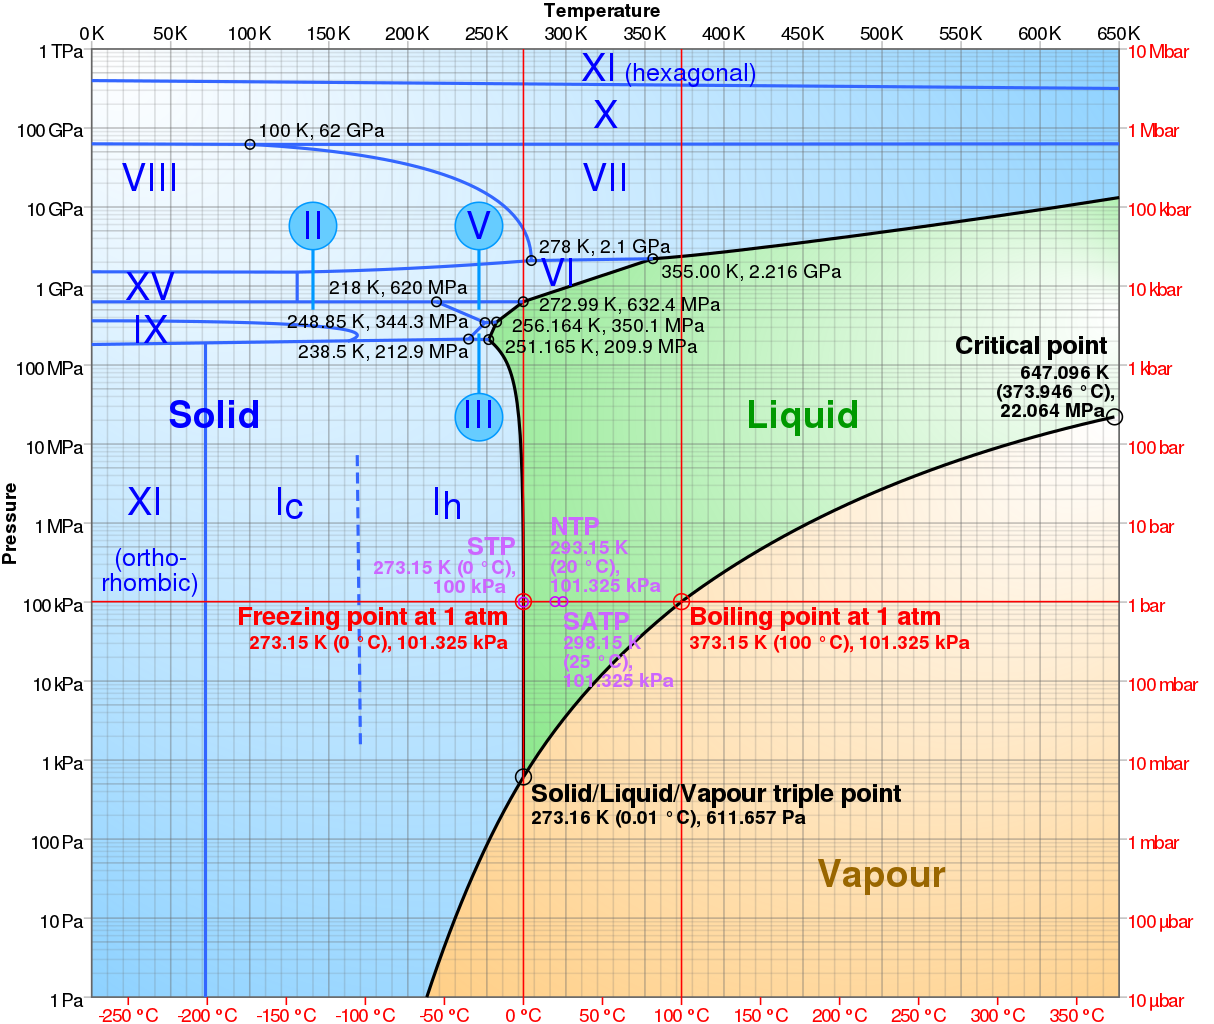